# How to take account of the slit position when computing line intensities (even for a spherical nebula)

In [1]:
%matplotlib inline 
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import pyCloudy as pc
# Changing the location and version of the cloudy executable.
pc.config.cloudy_exe = '/usr/local/Cloudy/c17.00/source/cloudy.exe'
from pyCloudy.utils.astro import conv_arc

In [3]:
# The directory in which we will have the model
# You may want to change this to a different place so that the current directory
# will not receive all the Cloudy files.
dir_ = '/tmp/'

In [4]:
# Define some parameters of the model:
model_name = 'model_4'
full_model_name = '{0}{1}'.format(dir_, model_name)
dens = 4. #log cm-3
Teff = 45000. #K
qH = 47. #s-1
r_min = 5e16 #cm
dist = 1.26 #kpc

In [5]:
# these are the commands common to all the models (here only one ...)
options = ('no molecules',
            'COSMIC RAY BACKGROUND',
            )

In [6]:
emis_tab = ['H  1  4861.36A',
            'H  1  6562.85A',
            'Ca B  5875.64A',
            'N  2  6583.45A',
            'O  1  6300.30A',
            'O  2  3726.03A',
            'O  2  3728.81A',
            'O  3  5006.84A',
            'BLND  4363.00A']

In [7]:
abund = {'He' : -0.92, 'C' : 6.85 - 12, 'N' : -4.0, 'O' : -3.40, 'Ne' : -4.00, 
         'S' : -5.35, 'Ar' : -5.80, 'Fe' : -7.4, 'Cl' : -7.00}

In [8]:
# Defining the object that will manage the input file for Cloudy
c_input = pc.CloudyInput(full_model_name)

In [9]:
# Filling the object with the parameters
# Defining the ionizing SED: Effective temperature and luminosity.
# The lumi_unit is one of the Cloudy options, like "luminosity solar", "q(H)", "ionization parameter", etc... 
c_input.set_BB(Teff = Teff, lumi_unit = 'q(H)', lumi_value = qH)

In [10]:
# Defining the density. You may also use set_dlaw(parameters) if you have a density law defined in dense_fabden.cpp.
c_input.set_cste_density(dens)

In [11]:
# Defining the inner radius. A second parameter would be the outer radius (matter-bounded nebula).
c_input.set_radius(r_in=np.log10(r_min))
c_input.set_abund(ab_dict = abund, nograins = True)
c_input.set_other(options)
c_input.set_iterate() # (0) for no iteration, () for one iteration, (N) for N iterations.
c_input.set_sphere() # () or (True) : closed geometry, or (False): open geometry.
c_input.set_emis_tab(emis_tab) # better use read_emis_file(file) for long list of lines, where file is an external file.
c_input.set_distance(dist=dist, unit='kpc', linear=True) # unit can be 'kpc', 'Mpc', 'parsecs', 'cm'. If linear=False, the distance is in log.

In [12]:
# Writing the Cloudy inputs. to_file for writing to a file (named by full_model_name). verbose to print on the screen.
c_input.print_input(to_file = True, verbose = False)

In [13]:
# Running Cloudy with a timer. Here we reset it to 0.
pc.log_.timer('Starting Cloudy', quiet = True, calling = 'test1')
c_input.run_cloudy()
pc.log_.timer('Cloudy ended after seconds:', calling = 'test1')

   test1: Cloudy ended after seconds: in 62.43903040885925


In [14]:
c_output = pc.CloudyModel(full_model_name)
c_output.print_stats()

 Name of the model: /tmp/model_4
 R_in (cut) = 5.000e+16 (5.000e+16), R_out (cut) = 9.544e+16 (9.544e+16)
 H+ mass = 2.57e-02, H mass = 2.62e-02
 <H+/H> = 0.99, <He++/He> = 0.00, <He+/He> = 0.89
 <O+++/O> = 0.00, <O++/O> = 0.56, <O+/O> = 0.43
 <N+++/O> = 0.01, <N++/O> = 0.66, <N+/O> = 0.33
 T(O+++) = 8930, T(O++) = 8593, T(O+) = 9078
 <ne> = 10844,  <nH> = 10000, T0 = 8803, t2=0.0024
 <log U> = -2.31


In [15]:
# define the size of the 3D cube and instanciate the object that manage it.
cube_size = 201
M_sphere = pc.C3D(c_output, dims=cube_size, center=True, n_dim=1)

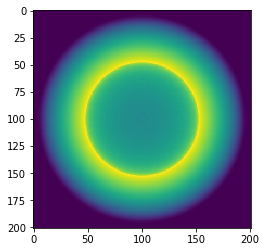

In [16]:
# plot the image of the OIII emission
plt.imshow(M_sphere.get_emis('O__3_500684A').sum(0));

In [17]:
# A function in form of lambda to transform size in cm into arcsec, for a distance "dist" defined above.
arcsec = lambda cm: conv_arc(dist=dist, dist_proj=cm)

In [18]:
def make_mask(ap_center=[0., 0.], ap_size=[1., 1.]):
    """
    This returns a mask (values between 0. and 1.) to be multiplied to the image to take the flux passing through an aperture.
    An pc.C3D object named M_sphere must exist outside theis function
    """
    x_arc = arcsec(M_sphere.cub_coord.x_vec)
    y_arc = arcsec(M_sphere.cub_coord.y_vec)
    z_arc = arcsec(M_sphere.cub_coord.z_vec)
    X, Y = np.meshgrid(y_arc, x_arc)
    bool_mask = ((X > ap_center[0] - ap_size[0]/2.) & 
            (X <= ap_center[0] + ap_size[0]/2.) & 
            (Y > ap_center[1] - ap_size[1]/2.) & 
            (Y <= ap_center[1] + ap_size[1]/2.))
    mask = np.zeros_like(X)
    mask[bool_mask] = 1.0
    return mask

In [19]:
# we define the mask. Can be change to see the effect of the aperture on line intensities
mask = make_mask(ap_center=[1.5, 2.3], ap_size=[50, 1.5])

In [21]:
# Check that the mask is not empty
print(mask.size)
print(mask.sum())

40401
6030.0


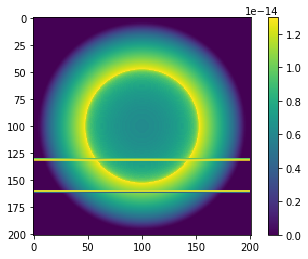

In [22]:
# We plot the OIII image and overplot the mask.
plt.imshow(M_sphere.get_emis('O__3_500684A').sum(0), interpolation='None')
plt.colorbar()
plt.contour(mask);


In [24]:
# Hbeta is computed for the whole object and throught the aperture
Hb_tot = (M_sphere.get_emis('H__1_486136A')*M_sphere.cub_coord.cell_size).sum()
Hb_slit = ((M_sphere.get_emis('H__1_486136A')*M_sphere.cub_coord.cell_size).sum(1) * mask).sum()
print(Hb_tot, Hb_slit)

4.66376696465e+34 8.8546186899e+33


In [25]:
# For every line, we compute the intensity for the whole object and throught the aperture.
# We also print out the difference due to the slit.
for label in M_sphere.m[0].emis_labels:
    I_tot = (M_sphere.get_emis(label).sum()*M_sphere.cub_coord.cell_size) / Hb_tot
    I_slit = ((M_sphere.get_emis(label).sum(1) * mask).sum()*M_sphere.cub_coord.cell_size) / Hb_slit
    print('line: {0:12s} I/Ib Total: {1:6.4f} I/Ib Slit: {2:6.4f} Delta: {3:4.1f}%'.format(label, I_tot, I_slit, 
                                                                                           (I_slit-I_tot)/I_tot*100))

line: H__1_486136A I/Ib Total: 1.0000 I/Ib Slit: 1.0000 Delta: -0.0%
line: H__1_656285A I/Ib Total: 2.7969 I/Ib Slit: 2.7970 Delta:  0.0%
line: CA_B_587564A I/Ib Total: 0.1644 I/Ib Slit: 0.1674 Delta:  1.8%
line: N__2_658345A I/Ib Total: 1.1131 I/Ib Slit: 0.9669 Delta: -13.1%
line: O__1_630030A I/Ib Total: 0.0151 I/Ib Slit: 0.0123 Delta: -19.1%
line: O__2_372603A I/Ib Total: 0.7818 I/Ib Slit: 0.6911 Delta: -11.6%
line: O__2_372881A I/Ib Total: 0.3481 I/Ib Slit: 0.3075 Delta: -11.7%
line: O__3_500684A I/Ib Total: 3.7737 I/Ib Slit: 3.9971 Delta:  5.9%
line: BLND_436300A I/Ib Total: 0.0153 I/Ib Slit: 0.0161 Delta:  5.1%
